## **Experimental data in KICT**

- Inputs: Wave (i.e., height)
- Outputs: Structural responses (i.e., acc, tilt, disp)

writteny by seungsab (2022.11.15)

<center> <p>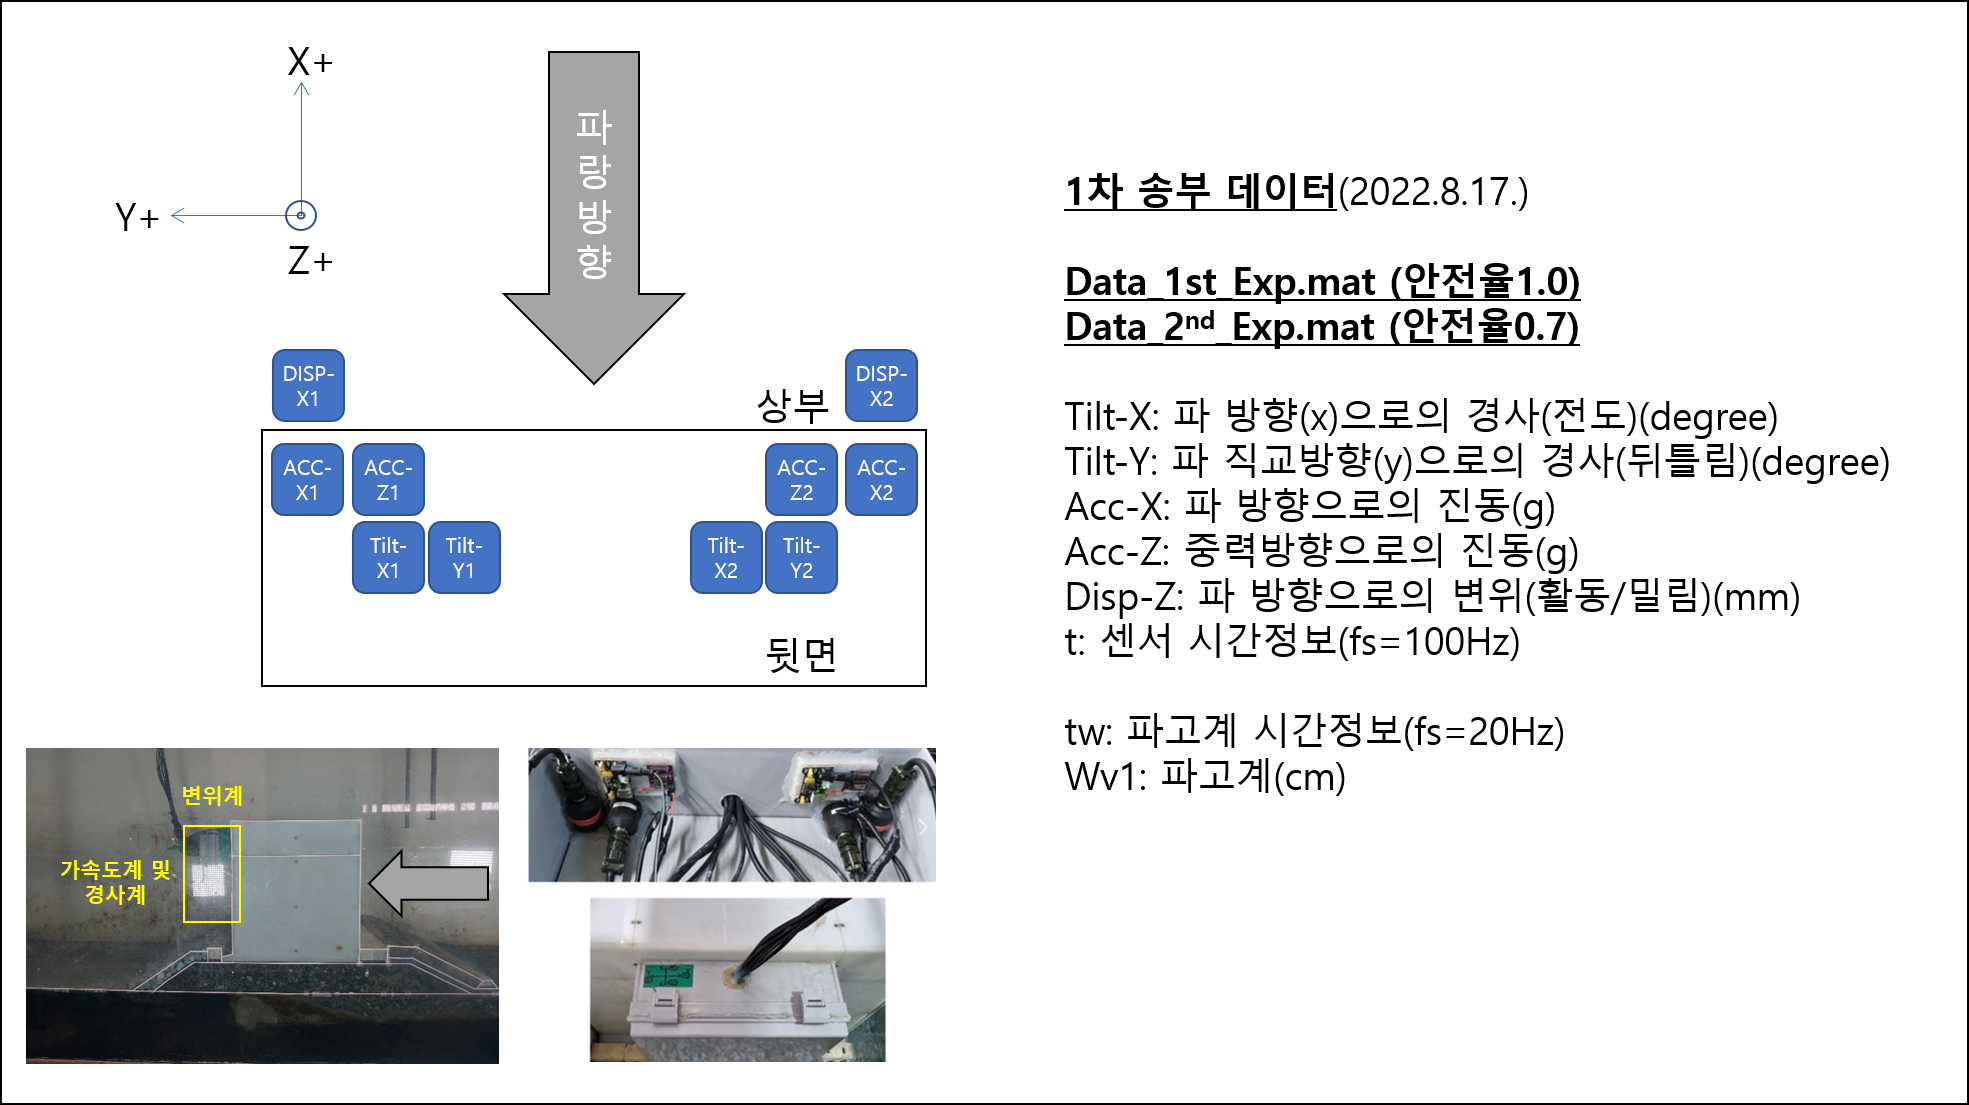</p> </center>

#### **Import Libraries**

In [7]:
import pandas as pd
import numpy as np
import scipy.io

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

#### **Step #1: Load Preprocessed data**

In [8]:
df = 100/4096
f = np.arange(0, 4096*df, df)

exp_type = '2nd'

if exp_type is '2nd':
    df_PSD0 = pd.read_csv('PSD_2nd_EXP_reduced.csv', header = None)
    f = f[:df_PSD0.shape[1]]
    df_PSD0.columns = f

    df_label0 = pd.read_csv('Label_2nd_EXP_reduced.csv', header = None)
    df_label0.columns = ['label']
else:
    df_PSD0 = pd.read_csv('PSD_3rd_EXP_reduced.csv', header = None)
    df_PSD0 = pd.DataFrame(np.log(df_PSD0.values))
    f = f[:df_PSD0.shape[1]]
    df_PSD0.columns = f

    df_label0 = pd.read_csv('Label_3rd_EXP_reduced.csv', header = None)
    df_label0.columns = ['label']

##### ***Plot labels and PSD***

In [9]:
def plot_PSD(df_PSD0, f, ind1, ind2):
    plt.figure(figsize = (10, 4), dpi = 200)
    IND_line_obj = np.arange(0, df_PSD0.shape[0])
    
    for ind in range(df_PSD0.shape[1]):
        plt.scatter(f[ind] * np.ones_like(df_PSD0.iloc[ind1[0]:ind1[1], ind]), df_PSD0.iloc[ind1[0]:ind1[1], ind], 
        s = 3, alpha = 0.2, c = np.arange(ind1[0], ind1[1]), cmap = 'jet')

    IND_line_obj = np.arange(ind2[0], ind2[1])
    for ind in range(df_PSD0.shape[1]):
        plt.scatter(f[ind] * np.ones_like(df_PSD0.iloc[ind2[0]:ind2[1], ind]), df_PSD0.iloc[ind2[0]:ind2[1], ind],
        s = 3, alpha = 0.2, c = np.arange(ind2[0], ind2[1]), cmap = 'jet')

    plt.grid(ls = ':', color = 'gray')
    plt.xlabel('Freq. (Hz)')
    plt.ylabel('Power Spectral Density (PSD) in log-scale')
    plt.title(f"{ind1[0]}~{ind1[1]} // {ind2[0]}~{ind2[1]}")
    plt.colorbar(label='# Time Index')
    plt.clim(ind1[0], ind2[1])
    plt.show()

In [10]:
event_index = []
for event_int in np.unique(df_label0['label']):
    if event_int != 0:
        event_index.append(np.where(df_label0.values == event_int)[0][0])
event_index

[659, 675, 1051, 1100, 1353, 1453, 1578, 1634]

#### **Step #2: Split Train and Test datasets**

##### ***Plot train/valid/test datasets***

In [11]:
def run_online_offline_all(train_ratio, df_label0):
# Normal data
    bool_normal = (df_label0['label'] == 0)
    ind_train = int(df_PSD0[bool_normal].shape[0] * train_ratio)

    # Split train and test datasets
    Xtrain, Ytrain = df_PSD0.iloc[:ind_train, :], df_label0[:ind_train]
    Xvalid, Yvalid = df_PSD0.iloc[ind_train:df_PSD0[bool_normal].shape[0], :], df_label0[ind_train:df_PSD0[bool_normal].shape[0]]
    Xtest, Ytest = df_PSD0.iloc[df_PSD0[bool_normal].shape[0]:, :], df_label0[df_PSD0[bool_normal].shape[0]:]

    plt.figure(figsize = (10, 4), dpi = 200)
    plt.scatter(Ytrain.index, Ytrain.values, c = 'b', label = 'Train')
    plt.scatter(Yvalid.index, Yvalid.values, c = 'g', label = 'Valid')
    plt.scatter(Ytest.index, Ytest.values, c = 'r', label = 'Test')
    plt.grid(ls = ':', color = 'gray')
    plt.gca().set_yticklabels((['o', 'Normal'] + [f'Shift#{ind + 1}' for ind in range(8)]))
    plt.xlabel('# Time Index')
    plt.ylabel('Label for Event')
    plt.legend()
    plt.show()

    # Define train and test data
    Xtrain_ = Xtrain.values
    Xvalid_ = Xvalid.values
    Xtest_ = Xtest.values

    from Utils.SS_Anomaly_Online_learning import pca_online
    
    Xnew = np.concatenate([Xvalid_, Xtest_], axis = 0)    
    anomaly_setting = {
        "method_Ncomp" : 'eigengap', # 'CPV' // 'eigengap'
        "alpha" : 0.9999,
        "cutoff" : 0.99,
        "component_use" : 'major', # 'major' // 'minor'
        "method_thresh" : 'threhold_from_Gaussian', # percentile
        "gmm_run" : False, # True // False
    }

    Anomaly_detector = pca_online(**anomaly_setting)
    Anomaly_detector.fit_initial_pca(Xtrain_)
    Anomaly_detector.fit_offline_pca(Xnew)
    Anomaly_detector.plot_result(f'One-shot Learning // # Initial sample: {Xtrain_.shape[0]}', df_label0)

    anomaly_setting = {
        "method_Ncomp" : 'eigengap', # 'CPV' // 'eigengap'
        "alpha" : 0.9999,
        "cutoff" : 0.99,
        "component_use" : 'major', # 'major' // 'minor'
        "method_thresh" : 'threhold_from_Gaussian', # percentile
        "gmm_run" : False, # True // False
    }

    Anomaly_detector = pca_online(**anomaly_setting)
    Anomaly_detector.fit_initial_pca(Xtrain_)

    for ind, x in enumerate(Xvalid_):
        print(f'Valid: {ind} // {Xvalid_.shape[0]}', end = '\r')
        Xnew = x.reshape(1, -1)
        Anomaly_detector.fit_online_pca(Xnew)

    for ind, x in enumerate(Xtest_):
        print(f'Test: {ind} // {Xtest_.shape[0]}', end = '\r')
        Xnew = x.reshape(1, -1)
        Anomaly_detector.fit_online_pca(Xnew)

    Anomaly_detector.plot_result(f'Online Learning // # Initial sample: {Xtrain_.shape[0]}', df_label0)

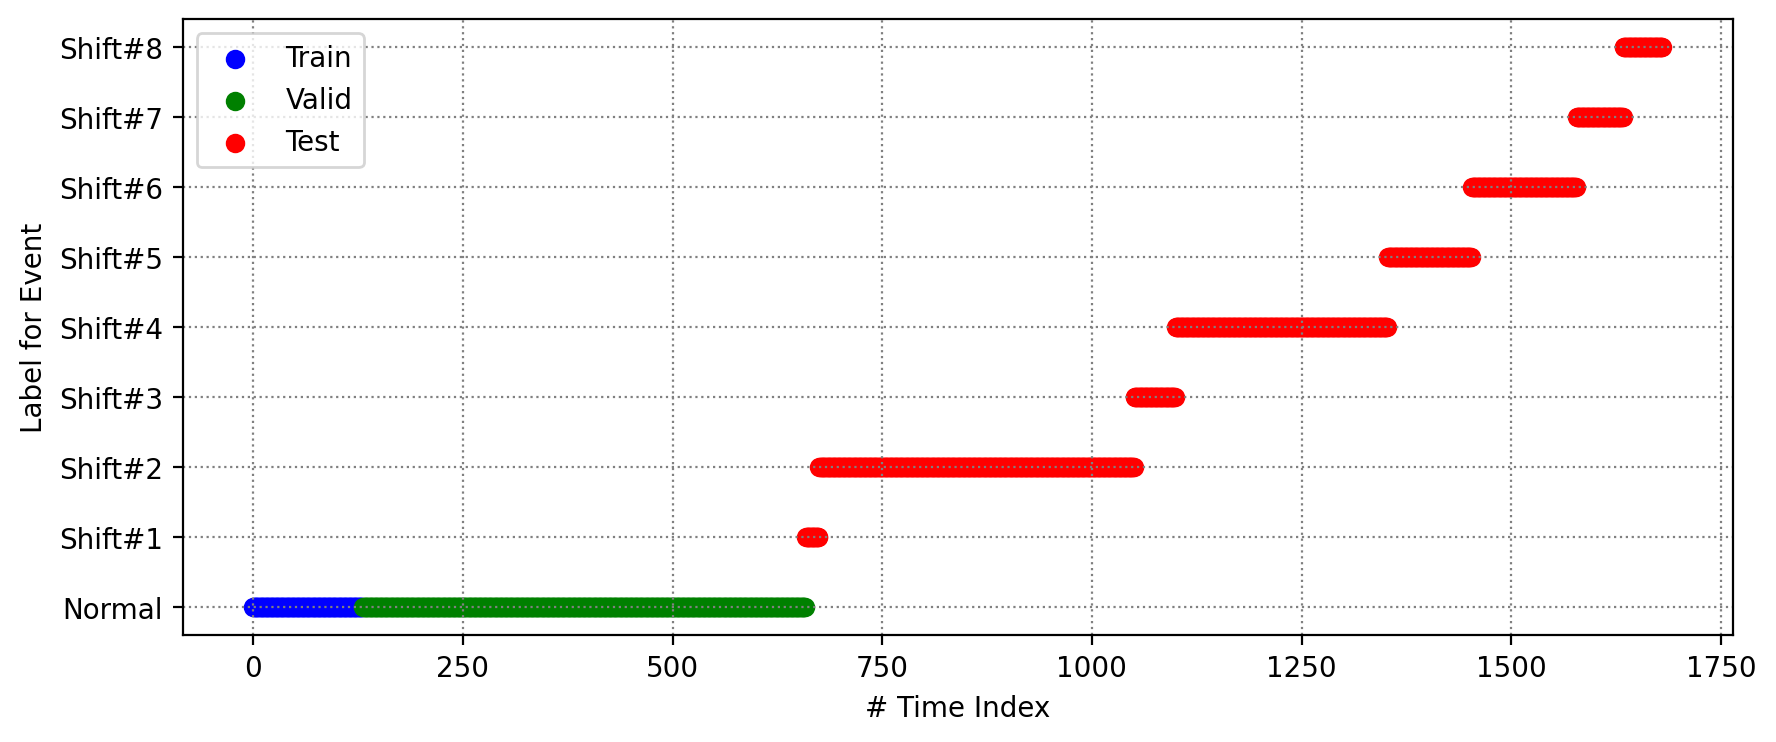

[ 45.02147231  46.78082725  45.87670851 ... 522.99472611 522.92683307
 525.69856853]


NameError: name 'event_index' is not defined

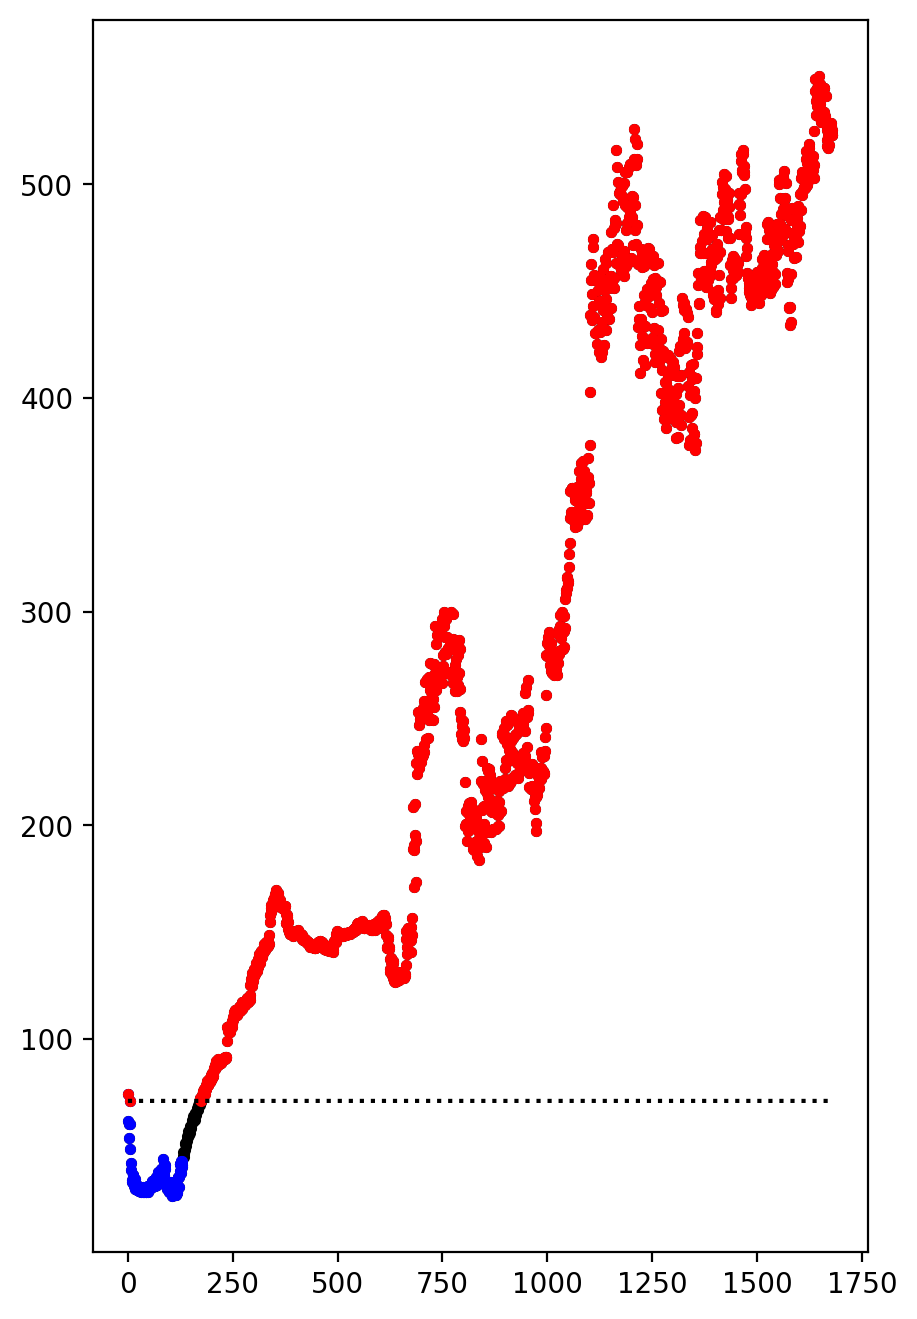

In [12]:
train_ratio = 0.2
run_online_offline_all(train_ratio, df_label0)

In [ ]:
train_ratio = 0.5
run_online_offline_all(train_ratio, df_label0)

In [ ]:
train_ratio = 0.8
run_online_offline_all(train_ratio, df_label0)

In [ ]:
659*0.2

In [ ]:
df_label0.shape